<a href="https://colab.research.google.com/github/uliebal/RWTH-QMB1/blob/master/1904_QuantMiBi2_CobraPy_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar Quantitativ Microbiology 2: 
# Simulation of Genome Scale Metabolic Models with CobraPy

## Introduction
The seminar provides a guide of how to work with genome scale metabolic models (GSMM) of micro-organisms. This seminar extends the introduction to CobraPy from the seminar in Quantitative Microbiology 1. The goal of this seminar is to identify minimal medium composition, extract information about and selecting the appropriate biomass composition formula and testing the reproduction of experimental data by the GSMM. We examine a recent model of *P. pastoris* ([Tomas-Gamisans et al., 2017](https://dx.doi.org/10.1111/1751-7915.12871)). This organism is of biotechnological relevance because it can glycosylate recombinant proteins for use as drugs and it can metabolize methanol as a potential alternative to petrol based chemistry ([Liebal et al., 2018](https://dx.doi.org/10.1016/j.mec.2018.e00075)).

We will analyse the GSMM of *P. pastoris* to estimate for the exchange reactions the range of permissible flux values. This indicates which phenotypes we can expect during standard cultivation and can highlight easily overproduced metabolites. Subsequently, we will identify the minimal medium composition. An important property of GSMM is their ability to predict growth rates. We will extract experimentally measured growth rates for various substrates and compare them with predictions of the model. The data reproduction is exemplified with the substrates of methanol and glycerol and the self-learning task is to supplement growth rates based on glucose uptake rate from literature ([Lehnen et al., 2017](https://dx.doi.org/10.1016/j.meteno.2017.07.001))

The seminar uses Jupyter notebooks, a new way to use and visualize code in the web. Such a notebook is composed of a sequence of cells. Cellls can be either text/comments, like this introduction, or it contains python code to be run. In this example the code is evaluated by the cloud service [Binder](https://mybinder.org/). The output for each code-cell is shown directly below it. For a overview on Jupyter notebooks read [this review](https://www.nature.com/articles/d41586-018-07196-1). Another usefull resource to develop Jupyter notebooks is via [Google Colaboration](https://colab.research.google.com).


---

## Tutorial Steps
  * Set up of Python environment
    * Basic libraries(sys, pandas, numpy, matplotlib, zipfile, cobrapy)
  * Analysis of Genome Scale Metabolic Model
    * Retrieval of GSMM for *P. pastoris*
    * Flux variability on exchange reactions
    * Minimal medium composition
  * Experimental growth rate reproduction
    * Familiarizing with biomass composition reactions
    * Defining functions for correct biomass equation switch
    * Data retrieval
    * Simulation loop
    * Graphical output


## Set-up compute environment

Before we can analyse GSMM, we have adjust the python environment that it integrates the cobrapy toolbox and downloading the GSMM.

### Basic Python libraries 
Some libraries that facilitate data manipulation

In [0]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
# !{sys.executable} -m pip install pandas
import pandas as pd

# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# in order to extraact the GSMM we need to process zip-files
import zipfile

### Git-Installation of cobrapy

In [0]:
# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
!{sys.executable} -m pip install git+https://github.com/opencobra/cobrapy;
from cobra.io import read_sbml_model


### GSMM download from original publication

*P. pastoris* is an important biotechnological organism and several GSMMs have been generated. We will use the model generated by [Tomas-Gamisans et al., 2017](https://dx.doi.org/10.1111/1751-7915.12871). First, we download the zipped model and extract it. Subsequently we load it into cobra.

In [0]:
!wget https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5743807/bin/MBT2-11-224-s003.zip
with zipfile.ZipFile('MBT2-11-224-s003.zip', 'r') as zip_ref:
  zip_ref.extractall()


In [0]:
# capture (i.e. suppress) output, because hundreds of warnings are generated
%%capture
# generating cobra variable from SBML/xml file
model = read_sbml_model('/content/folder/mbt212871-sup-0003-AppendixS3.xml');

In [6]:
# check on model consistency
model

Name,iMT1026v3
Memory address,0x07f6306b9d978
Number of metabolites,1706
Number of reactions,2237
Number of groups,65
Objective expression,1.0*Ex_biomass - 1.0*Ex_biomass_reverse_5354f
Compartments,"Vacuole, Cytosol, Mitochondria, Peroxisome, Extracellular space, Endoplasmic Reticulum, Golgi Apparatus, Nucleus, Mitochondrial intermembrane space"


### Flux variability of exchange reactions

Flux balance analysis provides a single optimal solution. Mostly, there exist a number of alternative flux distributions around the optimum, which can be physiologically relevant. To identify the variability of exchange fluxes around the optimum solution 'flux variability analysis' can be performed ([Mahadevan & Schilling, 2003](http://dx.doi.org/10.1016/j.ymben.2003.09.002)).

In [8]:
solution = model.optimize()
model.summary(fva=.95) # additional argument specifies allowed deviation from the optimum

IN FLUXES                            OUT FLUXES                           OBJECTIVES
-----------------------------------  -----------------------------------  ------------------
id         Flux  Range               id           Flux  Range             Ex_biomass  0.0587
------  -------  ------------------  ---------  ------  ----------------
o2_e    1.42     [1.36, 1.52]        h2o_e      2.69    [2.59, 203]
glyc_e  1        [0.957, 1]          co2_e      0.946   [0.849, 1.05]
nh4_e   0.364    [0.346, 0.378]      h_e        0.381   [0.585, -1e+03]
pi_e    0.0148   [0.014, 1e+03]      biomass_e  0.0587  [0.0557, 0.0587]
so4_e   0.00257  [0.00244, 0.00322]  etoh_e     0       [0, 0.0533]
                                     cit_e      0       [0, 0.0333]
                                     abt_D_e    0       [0, 0.0268]
                                     fab_e      0       [0, 0.00274]


### Media test
The availability of nutrients has a major impact on metabolic fluxes and cobrapy provides some helpers to manage the exchanges between the external environment and the metabolic model. More detailed descriptions: [here](https://cobrapy.readthedocs.io/en/latest/media.html)

In [9]:
from cobra.medium import minimal_medium

max_growth = model.slim_optimize()
minimal_medium(model, max_growth, minimize_components=True)


Ex_nh4     0.363899
Ex_pi      0.014758
Ex_o2      1.417765
Ex_so4     0.002573
Ex_glyc    1.000000
dtype: float64

## Integration of experimental growth rates o different substrates

### Adaptation of Biomass Composition

In [10]:
# List of all reactions with 'BIOMASS' in their name
model.reactions.query('BIOMASS')

[<Reaction BIOMASS at 0x7f6305a41cf8>,
 <Reaction BIOMASS8020 at 0x7f63055eacf8>,
 <Reaction BIOMASS6040 at 0x7f63055ead30>,
 <Reaction BIOMASS4060 at 0x7f63055eac50>,
 <Reaction BIOMASS8020b at 0x7f63055eaf28>,
 <Reaction BIOMASS6040b at 0x7f63055eada0>,
 <Reaction BIOMASS4060b at 0x7f63055f7e80>,
 <Reaction BIOMASS_glyc at 0x7f630553f7f0>,
 <Reaction BIOMASS_meoh at 0x7f630553f518>]

In [15]:
# Looking in detail to biomass with methanol
model.reactions.BIOMASS_meoh

Reaction identifier,BIOMASS_meoh
Name,Biomass composition (g/g)- Methanol
Memory address,0x07f630553f518
Stoichiometry,0.2724 CARBOHYDRATES_c + 0.0018 DNA_c + 0.0197 LIPIDS_c + 0.5023 PROTEIN_c + 0.0649 RNA_c + 166.771 atp_c + cof_c + 166.771 h2o_c --> 166.771 adp_c + biomass_c + 166.771 h_c + 166.771 pi_c 0.2724 Carbohydrates + 0.0018 DNA + 0.0197 Lipids + 0.5023 PROTEIN + 0.0649 RNA + 166.771 ATP + Cofactors and small molecules + 166.771 H2O --> 166.771 ADP + Biomass + 166.771 H+ + 166.771 Phosphate
GPR,
Lower bound,0.0
Upper bound,0.0


In [0]:
def AdaptMethanol(model, meoh_up):
  # setting uptake reactions right
  model.reactions.Ex_glc_D.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_meoh.lower_bound = -np.abs(meoh_up)
  # setting additional biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 1000
  model.reactions.PROTEINS_meoh.upper_bound = 1000
  model.reactions.STEROLS_meoh.upper_bound = 1000
  model.reactions.BIOMASS_meoh.upper_bound = 1000
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS.upper_bound = 0
  model.reactions.PROTEINS.upper_bound = 0
  model.reactions.STEROLS.upper_bound = 0
  model.reactions.BIOMASS.upper_bound = 0  
  model.objective = 'BIOMASS_meoh'
  return model

def AdaptGlycerol(model, glyc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0;
  model.reactions.Ex_glc_D.lower_bound = 0;
  model.reactions.Ex_glyc.lower_bound = -np.abs(glyc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS_glyc.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS_glyc'
  return model

def AdaptGlucose(model, glc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_glc_D.lower_bound = -np.abs(glc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS'
  return model

### Loading data
Data Address: [here](https://rwth-aachen.sciebo.de/s/o72jwWQWh3ame1e/download)

In [24]:
data = pd.read_csv('/content/Opol-expt-grwth_all.csv')
# data = pd.read_csv('/content/Opol-expt-grwth_MeOH-Glyc.csv')
data.head(9)


,Substrate,Exchange,uptake rate (mmol/gCDW/h),Experiment growth rate (/h),source
0,Methanol,Ex_meoh,2.343750,0.024,van Dijken et al. (Fig.6)(10.1007/BF00446560)
1,Methanol,Ex_meoh,2.935606,0.031,van Dijken et al. (Fig.6)(10.1007/BF00446560)
2,Methanol,Ex_meoh,4.285714,0.048,van Dijken et al. (Fig.6)(10.1007/BF00446560)
3,Methanol,Ex_meoh,5.827703,0.069,van Dijken et al. (Fig.6)(10.1007/BF00446560)
4,Methanol,Ex_meoh,6.578947,0.080,van Dijken et al. (Fig.6)(10.1007/BF00446560)
5,Methanol,Ex_meoh,9.868421,0.120,van Dijken et al. (Fig.6)(10.1007/BF00446560)
6,Methanol,Ex_meoh,14.285714,0.160,van Dijken et al. (Fig.6)(10.1007/BF00446560)
7,Glycerol,Ex_glyc,7.125407,0.420,de Koning et al. (10.1007/BF00456710) and Moo...
8,Glucose,Ex_glc_D,5.900000,0.600,Lehnen et al. (10.1016/j.meteno.2017.07.001)


### Simulating Experiment
For-Loop over all experimental data points.

In [25]:
growth_simulated = [];
with model as test_model:
# test_model = model.copy()
  # iteration over all rows in 'data'
  for index, row in data.iterrows():
    print(index) # printing the row number to get feedback that everything is working
    # selecting the right substrate in the model based on 'Substrate' in 'data'
    if row['Substrate'] == 'Methanol':
      model = AdaptMethanol(test_model, row['uptake rate (mmol/gCDW/h)'])
    elif row['Substrate'] == 'Glucose':
      model = AdaptGlucose(test_model, row['uptake rate (mmol/gCDW/h)'])
    elif row['Substrate'] == 'Glycerol':
      model = AdaptGlycerol(test_model, row['uptake rate (mmol/gCDW/h)'])
    else:
      print('substrate not considered')      
#     model.optimize()
    growth_simulated.append(model.slim_optimize())


0
1
2
3
4
5
6
7
8


### Plotting results

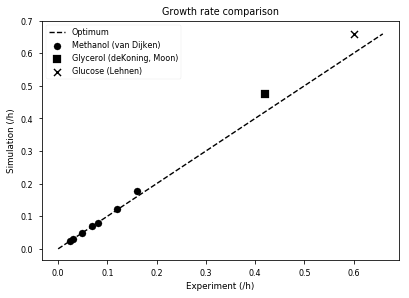

In [54]:
plt.scatter(data['Experiment growth rate (/h)'][0:7], growth_simulated[0:7], s=50, c='k', marker='o', );
plt.scatter(data['Experiment growth rate (/h)'][7], growth_simulated[7], s=50, c='k', marker='s');
plt.scatter(data['Experiment growth rate (/h)'][8], growth_simulated[8], s=50, c='k', marker='x');plt.xlabel('Experiment (/h)');
plt.ylabel('Simulation (/h)');
myline = np.linspace(0,np.max(growth_simulated),10);
plt.plot(myline,myline,'k--');
plt.title('Growth rate comparison');
plt.legend(['Optimum','Methanol (van Dijken)','Glycerol (deKoning, Moon)','Glucose (Lehnen)'], loc=2);
plt.style.use('seaborn-paper')

# Saving figure
plt.savefig('iMT1026_exp-vs-sim.png')